# 导入

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition as skldec   #PCA降维
from sklearn import manifold  #tSNE降维
import numpy as np
from sklearn.preprocessing import MinMaxScaler  #归一化
from scipy.cluster import hierarchy  #层次聚类
import seaborn as sns
import random

# 神经网络NN

In [169]:
import tensorflow as tf

In [128]:
df_all_CC_0401 = data_import_process('Ab+EV_dimen_reduc_01.20.xlsx', 'all_CC')
df_all_CC_0401

,Imp_contrast_change,Size/nm,CD63_contrast_change,EpCAM_contrast_change,CD81_contrast_change,type,type_num
ID,,,,,,,
A549_1,0.108057,0.265782,0.219858,0.378630,0.881313,A549,1
A549_2,0.101203,0.291094,0.257598,0.286345,0.881378,A549,1
A549_3,0.151974,0.410101,0.315599,0.363822,0.904874,A549,1
A549_4,0.180085,0.457567,0.390780,0.337392,0.921146,A549,1
A549_5,0.169457,0.441647,0.298271,0.409750,0.924270,A549,1
...,...,...,...,...,...,...,...
MCF7_46,0.167401,0.255875,0.271652,0.313143,0.871630,MCF7,3
MCF7_47,0.090751,0.178867,0.218915,0.304221,0.896862,MCF7,3
MCF7_48,0.110320,0.117066,0.360534,0.230336,0.905141,MCF7,3


In [170]:
df_all_CC_0401_train, df_all_CC_0401_test = split_train_test(df_all_CC_0401, df_all_CC_0401['type_num'])
df_all_CC_0401_train_x, df_all_CC_0401_train_y = num_cut(df_all_CC_0401_train, ['type_num','type'])
df_all_CC_0401_test_x, df_all_CC_0401_test_y = num_cut(df_all_CC_0401_test, ['type_num','type'])

In [171]:
COLUMNS = df_all_CC_0401.columns[[0,1,2,3,4,6]]
FEATURES = df_all_CC_0401.columns[0:5]
LABEL = df_all_CC_0401.columns[6]

my_feature_columns = []
for key in df_all_CC_0401_train_x.keys(): 
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='Imp_contrast_change', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Size/nm', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='CD63_contrast_change', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='EpCAM_contrast_change', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='CD81_contrast_change', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [172]:
#FEATURES = df_all_CC_0401.columns[0:5]
#LABEL = df_all_CC_0401.columns[6]

def input_fn(data_set):
    feature_cols = {k: tf.constant(data_set[k].values)
                  for k in FEATURES}
    labels = tf.constant(data_set[LABEL].values)
    return feature_cols, labels

In [173]:
# 定义函数，将数据存储为dataset格式，可以节省内存，并且方便并行读取
def input_fn_shuffle(features, labels, training=True, batch_size=256):
    "An input function for training or evaluating"
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels)) #将输入转换为数据集。
    if training:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(1000) #如果在训练模式下混淆并重复数据。
    return dataset.batch(batch_size)

In [108]:
my_model_dir=r'E:\University_2\课题组\202308 Imp_EV\Deep_learning\DNN_temp2'
classifier_2 = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,hidden_units=[30, 10],
                                        n_classes=3,model_dir=my_model_dir,) 
classifier_2.train(input_fn = lambda: input_fn_shuffle(df_all_CC_0401_train_x, df_all_CC_0401_train_y['type_num']), steps=10000) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'E:\\University_2\\课题组\\202308 Imp_EV\\Deep_learning\\DNN_temp2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
I

In [56]:
# 构建一个拥有两个隐藏层，隐藏节点分别为30和10的深度神经网络
my_model_dir=r'E:\University_2\课题组\202308 Imp_EV\Deep_learning\DNN'
classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,
                                        hidden_units=[30, 10], #隐藏层所含结点数量分别为30和10.
                                        n_classes=3, #分三类
                                        model_dir=my_model_dir,) #训练好的模型储存的位置

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'E:\\University_2\\课题组\\202308 Imp_EV\\Deep_learning\\DNN', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [90]:
classifier.train(input_fn = lambda: input_fn(df_all_CC_0401_train), steps=80000,) 
#每次运行会加载checkpoint并继续跑step步。

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from E:\University_2\课题组\202308 Imp_EV\Deep_learning\DNN\model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120000...
INFO:tensorflow:Saving checkpoints for 120000 into E:\University_2\课题组\202308 Imp_EV\Deep_learning\DNN\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120000...
INFO:tensorflow:loss = 0.39624366, step = 120000
INFO:tensorflow:global_step/sec: 742.059
INFO:tensorflow:loss = 0.39608756, step = 120100 (0.136 sec)
INFO:tensorflow:global_step/sec: 1026.16
INFO:tensorflow:loss = 0.39593184, step = 120200 (0.098 sec)
INFO:tensorflow:global_step/sec: 957.752
INFO:tensorflow:loss = 0.39577624, step = 120300 (0.104 sec)
INFO:tensorflow:global

In [105]:
test_result = classifier.evaluate(input_fn=lambda: input_fn(df_all_CC_0401_test), steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2024-04-22T00:59:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from E:\University_2\课题组\202308 Imp_EV\Deep_learning\DNN\model.ckpt-201000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Inference Time : 0.23162s
INFO:tensorflow:Finished evaluation at 2024-04-22-00:59:38
INFO:tensorflow:Saving dict for global step 201000: accuracy = 0.74, average_loss = 0.6321773, global_step = 201000, loss = 0.6321773
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 201000: E:\University_2\课题组\202308 Imp_EV\Deep_learning\DNN\model.ckpt-201000


## 尝试TensorBoard

In [188]:
import tempfile #临时文件系统
def create_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(5)), #输入层，输入形状为(None, 5)，None表示不限制样本数
        tf.keras.layers.Dense(30, activation='relu'), #全连接层，输出维度为30，激活函数为relu，输出形状为(None, 30)
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(5, activation="relu"),
        tf.keras.layers.Dense(4, activation='softmax')#全连接层，激活函数为softmax，用于多分类，输出形状为(None,3)
    ])
#log_dir = tempfile.mkdtemp() #创建一个临时目录，并返回该临时目录的路径。

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), #'adam',
              loss='sparse_categorical_crossentropy', #当label是顺序标签时(0,1,2), 用sparse_categorical_crossentropy;  
              metrics=['accuracy'], #label是独热编码时([001],[010],[100]), 用categorical_crossentropy作为损失函数
              steps_per_execution=10)
log_dir = r'E:\temp\2024-04-24_layer30_10_5_lr0.0005'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=2) # Enable histogram computation with each epoch.
model.fit(x=df_all_CC_0401_train_x,
          y=df_all_CC_0401_train_y['type_num'],
          epochs=4000,
          validation_data=(df_all_CC_0401_test_x, df_all_CC_0401_test_y['type_num']),
          callbacks=[tensorboard_callback])

Epoch 1/4000
6/6 [==============================] - 3s 432ms/step - loss: 1.3669 - accuracy: 0.4011 - val_loss: 1.3603 - val_accuracy: 0.3968
Epoch 2/4000
6/6 [==============================] - 0s 9ms/step - loss: 1.3585 - accuracy: 0.4011 - val_loss: 1.3521 - val_accuracy: 0.3968
Epoch 3/4000
6/6 [==============================] - 0s 21ms/step - loss: 1.3505 - accuracy: 0.4011 - val_loss: 1.3441 - val_accuracy: 0.3968
Epoch 4/4000
6/6 [==============================] - 0s 9ms/step - loss: 1.3424 - accuracy: 0.4011 - val_loss: 1.3368 - val_accuracy: 0.3968
Epoch 5/4000
6/6 [==============================] - 0s 22ms/step - loss: 1.3347 - accuracy: 0.4011 - val_loss: 1.3298 - val_accuracy: 0.3968
Epoch 6/4000
6/6 [==============================] - 0s 9ms/step - loss: 1.3280 - accuracy: 0.4011 - val_loss: 1.3231 - val_accuracy: 0.3968
Epoch 7/4000
6/6 [==============================] - 0s 23ms/step - loss: 1.3210 - accuracy: 0.4011 - val_loss: 1.3173 - val_accuracy: 0.3968
Epoch 8/4000
6/

In [119]:
%tensorboard --logdir "E:\temp"

Reusing TensorBoard on port 6006 (pid 9512), started 6:08:14 ago. (Use '!kill 9512' to kill it.)

In [70]:
#如果报错，先运行以下代码
%load_ext tensorboard

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for details and examples.

# 批处理

In [126]:
def data_import_process(file_name, sheet_name, type_2_num={'PS':0, 'A549':1, 'MCF10A':2, 'MCF7':3}, 
                        file_dir=r"E:\University_2\课题组\202308 Imp_EV\Dimen_Reduc_降维分析"):
    '根据文件地址导入数据，并归一化、加type'
    #导入数据
    file_dir = file_dir+ '\\' +file_name
    df_merge = pd.read_excel(file_dir, index_col=0, sheet_name=sheet_name) 
    #归一化.X的值按每列（max-min）的比例缩放到[0,1]区间
    df_normalized = MinMaxScaler((0,1)).fit_transform(df_merge)
    df_merge_norm = pd.DataFrame(df_normalized, columns=df_merge.columns, index=df_merge.index)
    #加Type
    df_merge_norm['type'] = [ index.split('_')[0] for index in df_merge_norm.index]
    df_merge_norm['type_num'] = [ type_2_num[i.split('_')[0]] for i in df_merge_norm.index]
    return df_merge_norm

# 机器学习

In [137]:
#函数库
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
def split_train_test(dataframe, dataframe_y, test_size=0.25, random_state=42):
    '随机划分训练集和测试集'
    split = StratifiedShuffleSplit(test_size = test_size, random_state = random_state)  #取25%测试集
    for train_index, test_index in split.split(dataframe, dataframe_y):
        train_set = dataframe.iloc[train_index]   #训练集
        test_set = dataframe.iloc[test_index]   #测试集
    return train_set, test_set

def num_cut(dataframe, columns):
    '拆分数值与type属性'
    data_cat = dataframe.loc[:, columns]
    data_num = dataframe.drop(columns=columns)  #去掉列
    return data_num, data_cat

### all Contrast change

In [16]:
df_all_CC_0401_train, df_all_CC_0401_test = split_train_test(df_all_CC_0401, df_all_CC_0401['type_num'])
df_all_CC_0401_train_x, df_all_CC_0401_train_y = num_cut(df_all_CC_0401_train, ['type_num','type'])
df_all_CC_0401_test_x, df_all_CC_0401_test_y = num_cut(df_all_CC_0401_test, ['type_num','type'])

In [142]:
forest_clf_0401 = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=100)
clf_result = ML_result(forest_clf_0401, df_all_CC_0401_train_x, df_all_CC_0401_train_y['type_num'], 
                       df_all_CC_0401_test_x, df_all_CC_0401_test_y['type_num'], 'RF', roc=0)
clf_result    #.iloc[:,[1,2]]

{'confmat_train': array([[14,  1,  0,  0],
        [ 1, 59,  9,  6],
        [ 2, 15, 39,  4],
        [ 0, 11,  5, 21]], dtype=int64),
 'accu_train': 0.7112299465240641,
 'confmat_test': array([[ 5,  0,  0,  0],
        [ 0, 22,  0,  3],
        [ 0,  5, 14,  1],
        [ 0,  6,  2,  5]], dtype=int64),
 'accu_test': 0.7301587301587301,
 'feature_importance': array([0.24780075, 0.31032091, 0.10902201, 0.190647  , 0.14220933])}

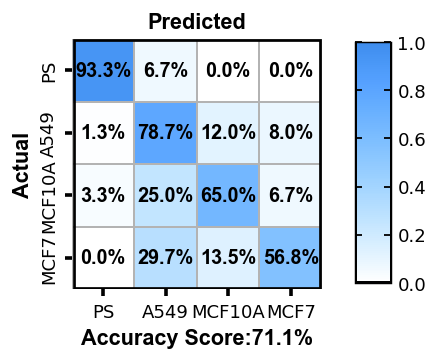

In [163]:
tick_label=['PS','A549','MCF10A','MCF7']
rect_set3={"xy1":(0.03,0.017), "width1":3.94, "height1":3.96,"linewidth1":1.5,
                    "xy2":(0.03,0.002), "width2":0.97, "height2":1,"linewidth2":1.1}
conf_mat_heatmap(clf_result['confmat_train'], label=None, rect_set=rect_set3,
                      xticklabel=tick_label, yticklabel=tick_label, save=0,) 

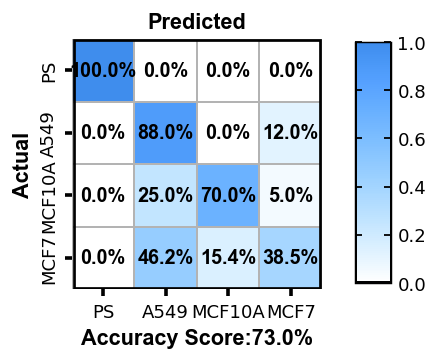

In [164]:
conf_mat_heatmap(clf_result['confmat_test'], label=None, rect_set=rect_set3,
                      xticklabel=tick_label, yticklabel=tick_label, save=0,) 

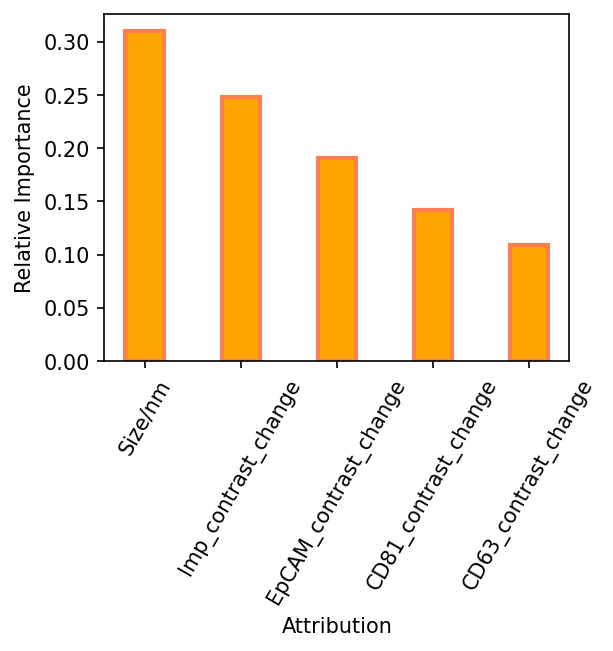

In [165]:
#每个特征重要性，将重要性和特征名组合起来，降序排列,columns取出表头
impo_df = pd.DataFrame(sorted(zip(clf_result['feature_importance'], df_all_CC_0401_train_x.columns), reverse=True)) 
fig, ax1 = plt.subplots(figsize=(4,3), dpi=150)
ax1.set_ylabel('Relative Importance',) #fontweight="bold"
ax1.set_xlabel('Attribution',)#fontweight="bold"
ax1.bar(x=impo_df[1], height=impo_df[0], edgecolor='coral', color='orange', linewidth=2, width=0.4) 
plt.xticks(rotation=60);  #y轴标签

# ML函数库

In [139]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score  #AUC

def ML_result(ML, X, y, X_test, y_test, label, roc=0, cmap=sns.color_palette('Dark2'), feedback=0):
    "传入ML算法，拟合、并输出混淆矩阵、准确度、或ROC-AUC"
    ML.fit(X, y) #拟合; 训练集
    y_pred = cross_val_predict(ML, X, y, cv=3)
    confmat_train = confusion_matrix(y, y_pred)
    accu_train = accuracy_score(y, y_pred)
    impo = ML.feature_importances_
    #测试集
    final_pred = ML.predict(X_test)
    confmat_test = confusion_matrix(y_test, final_pred) 
    accu_test = accuracy_score(y_test, final_pred)
    
    if roc != 0:
        if roc == "rf":
            y_probas_forest = cross_val_predict(ML, X, y, cv=3, method="predict_proba")  #输出分数值
            y_scores = y_probas_forest[:, 1] # score = proba of positive class
        if roc == "sgd":
            y_scores = cross_val_predict(ML, X, y, cv=3, method="decision_function")
        
        fpr, tpr, thresholds = roc_curve(y, y_scores)
        auc = roc_auc_score(y, y_scores)
        plot_roc_curve([fpr], [tpr], label=[label], auc=[auc], cmap=cmap)
        plt.show()
        if feedback == 1:
            return {"conf_mat":conf_mat, "accu":accu, "auc":auc,"fpr":fpr, "tpr":tpr}
        else:
            return {"conf_mat":conf_mat, "accu":accu, "auc":auc}
    return {"confmat_train":confmat_train, "accu_train":accu_train, 
            'confmat_test':confmat_test, "accu_test":accu_test, 'feature_importance':impo}

In [140]:
def plot_roc_curve(fpr, tpr, label, auc, cmap=None, save_path=None):
    fig, ax1 = plt.subplots(dpi=110)
    for i in range(len(fpr)):
        Label = "%s : %0.3f" % (label[i], auc[i])  #补全到长度为3，对齐用
        if cmap == None:
            ax1.plot(fpr[i], tpr[i], label = Label, linewidth=2.5,)
        else:
            ax1.plot(fpr[i], tpr[i], color=cmap[i], label=Label, linewidth=2.5,)
    
    ax1.plot([0, 1], [0, 1], linestyle='--', color='0.4')
    #ax1.set_ylim([0, 1.02])
    #plt.rcParams['font.sans-serif'] = ['Arial']
    #ax1.tick_params(axis='both', labelsize=13, labelcolor="k") #设置轴
    plt.xlabel('False Positive Rate', ) #fontsize=14, fontweight="bold"
    plt.ylabel('True Positive Rate', ) #fontsize=14, fontweight="bold"
    plt.legend(loc="lower right", prop={"size": 6, "weight":"bold", 'family':'Arial'}, frameon=False)
    if save_path != None:
        fig.savefig(save_path, bbox_inches='tight')

In [141]:
from sklearn.metrics import confusion_matrix
def conf_mat_heatmap(conf_mat, label, rect_set=None, xticklabel=['E','NE'], yticklabel=['E','NE'],
                     save=0, cmap=None, savepath=None,
                     ):
    if rect_set==None:
        rect_set={"xy1":(0.015,0.017), "width1":1.96, "height1":1.96,"linewidth1":2.2,
                    "xy2":(0.03,0.004), "width2":0.97, "height2":0.99,"linewidth2":1.1}
    fig = plt.figure(dpi=130, figsize=(2.5,2.5))
    #fig.subplots_adjust(right=0.8)  #在figure将右侧80%的位置留出空白，这样可以保证colorbar不会与绘制的图片重叠

    ax1 = fig.add_subplot(111)
    density_mat = conf_mat / np.sum( conf_mat, axis=1 ).reshape( conf_mat.shape[0], -1 )  #axis=1按行相加，并重塑到列向量
    if cmap==None:
        cmap = sns.cubehelix_palette(start=2.75, rot=0, gamma=1,hue=2, #hue饱和度,伽马值越大颜色越暗
                                     dark=0.5, light=1, #调色板中最暗\亮颜色的强度
                                     as_cmap=True)  #如果为 True 值，则返回 matplotlib colormap 而不是颜色列表
    h=sns.heatmap(data=density_mat, xticklabels=xticklabel, yticklabels=yticklabel, ax=ax1, annot = True,  #单元格写入值
                fmt=".1%", linewidths=1, linecolor="0.7", cbar=False,  #右侧图例(color bar)开关，默认为True显示
                annot_kws={'size':11,'weight':600,'family':"Arial",'color':"k"},  #设置格子中文本的大小size、'weight'粗细、颜色'color'
                square=True,  #如果为True，则使每个单元格为方形
                vmin=0, vmax=1, cmap=cmap,)
    ax1.tick_params( width=2, length=4, colors="k")
    rect = plt.Rectangle( xy=rect_set["xy1"], width=rect_set["width1"], height=rect_set["height1"],
                         fill=False, edgecolor="k", linewidth=rect_set["linewidth1"] )
    ax1.add_patch( rect )
    ################## 颜色条
    rect_cb = [1, 0.13, 0.11, 0.74]   #水平位置，垂直位置，水平宽度，垂直宽度[0.93, 0.19, 0.1, 0.63]
    cbar_ax = fig.add_axes( rect_cb )
    cb = h.figure.colorbar( h.collections[0], cax=cbar_ax, ) #显示colorbar
    #plt.rcParams['font.sans-serif']=['Arial']
    cb.ax.tick_params( direction='in', labelsize=10, length=4, width=1, colors="k",
                      left=True, right=True)      # 设置colorbar刻度字体大小
    #cb.set_ticklabels( ["0%", "20%", "40%", "60%", "80%", "100%"] )
    #cb.set_label('Normalized Percentage',size=9,weight= '600')
    rect2 = plt.Rectangle( xy=rect_set["xy2"], width=rect_set["width2"], height=rect_set["height2"],
                         fill=False, edgecolor="k", linewidth=rect_set["linewidth2"] )
    #rect2=plt.Rectangle(xy=(0.02,0.0),width=0.98,height=0.994,fill=False,edgecolor="k",linewidth=1)
    cbar_ax.add_patch( rect2 )
    ################## 字体和样式
    font1 = {'family': 'Arial',  #Microsoft JhengHei
                'color': 'k',
                'weight': 'bold', #取值normal|bold|heavy|lighter| 或100~900
                'size': 12,}
    ################## 轴标题
    accu=conf_mat.trace() / conf_mat.sum()  #总准确率：分类正确数（矩阵的迹）÷总数（矩阵每个元素之和）
    ax1.set_xlabel('Accuracy Score:{:.1%}'.format(accu), font1);  #字符串format方法
    #ax1.xaxis.tick_top()  #将x轴移到上方
    ax1.set_ylabel("Actual", font1); 
    ax1.set_title("Predicted", font1);
    ################### 每小格字体大小
    #ax1.tick_params(labelsize=12)
    #labels = ax1.get_xticklabels() + ax1.get_yticklabels()
    #[label.set_fontname('Arial') for label in labels];
    ################# 保存
    if save==1: 
        import datetime
        import os.path
        s_path = os.path.join(savepath,"conf_mat"+str(datetime.date.today())+label+".tiff")  #自动根据日期命名
        while os.path.exists(s_path)==True:  #判断是否重复
            temp = os.path.splitext(s_path)
            s_path = temp[0]+"A"+temp[1];
        fig.savefig(s_path,bbox_inches='tight')  #bbox_inches让图片显示完整，transparent=True让图片背景透明
    elif save==2:
        fig.savefig(savepath,bbox_inches='tight')
rect_set2={"xy1":(0.023,0.017), "width1":2.94, "height1":2.96,"linewidth1":2.2,
                    "xy2":(0.03,0.004), "width2":0.97, "height2":0.99,"linewidth2":1.1}